# Sony PS5 Price Analysis

by Daniel Dean, Pranav Penmetas, and Kempes Pandey

Today we will be looking at the difference in pricing of a popular video game console - the Sony PS5

In [ ]:
# importing all of the necessary packages
# -- might need tidying up
from datascience import *
import numpy as np
import re
from re import search
import requests
from bs4 import BeautifulSoup

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [ ]:
# mounting my drive to import csv files
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/CMPUT191_a3/'

Mounted at /content/drive


In [ ]:
# scrape_table function from video demo
import pandas as pd
def scrape_table(table):
    df = pd.read_html(str(table))
    df = pd.DataFrame(df[0])
    return Table.from_df(df)

In [ ]:
# currency conversion function from demo video
def convert(cur_from, cur_to, amount):
    payload = {
        'from': cur_from,
        'to': cur_to,
        'amount': amount,
        'api_key': '0a5659758c74b6dd01f96fdbc8fab87d'
    }
    r = requests.get('https://api.currencyscoop.com/v1/convert', params = payload)
    currency = r.json()
    return currency['response']['value']

In [ ]:
# correlation function from demo video
def standard_units(arr):
    """ Converts an array to standard units """
    return (arr - np.average(arr))/np.std(arr)

def correlation(t, x, y):
    """ Computes correlation: t is a table, and x and y are column names """
    x_standard = standard_units(t.column(x))
    y_standard = standard_units(t.column(y))
    return np.average(x_standard * y_standard)

In [ ]:
# scrape PS5 pricing data
ps5_pricing_url = 'https://www.theworldranking.com/statistics/160/playstation-5-prices-country/'
ps5_request = requests.get(ps5_pricing_url)
ps5_soup = BeautifulSoup(ps5_request.text, 'html.parser')
ps5_table = ps5_soup.find('table')
ps5_pricing = scrape_table(ps5_table)

<ipython-input-3-fa3cfb19b358>:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))


In [ ]:
# tidying up the data and converting to CAD
ps5_pricing = ps5_pricing.drop('Rank').take([12, 13, 20, 29, 34, 38, 42, 43, 55, 60, 70, 71, 73, 75, 76]) # select a more managable nnumber of countries to compare
def convert_to_CAD(price):
  USD_to_CAD_rate = 1.41
  return price * USD_to_CAD_rate

CAD_prices = ps5_pricing.apply(convert_to_CAD, 'USD ($)')
ps5_pricing = ps5_pricing.with_column('USD ($)', CAD_prices) # replace the prices in USD with CAD
ps5_pricing = ps5_pricing.relabeled("USD ($)", "Price (CAD)")
ps5_pricing

Country,Price (CAD)
China,1178.76
Brazil,1154.79
South Africa,1023.66
Poland,943.29
Mexico,909.45
Sweden,896.76
United Kingdom,874.2
South Korea,869.97
France,829.08
Russia,819.21


In [ ]:
# scrape CurrencyScoop country codes
currency_url = "https://currencyscoop.com/supported-currencies"
currency_request = requests.get(currency_url)
currency_soup = BeautifulSoup(currency_request.text, 'html.parser')
currency_table = currency_soup.find("table")
currency_codes = scrape_table(currency_table)

<ipython-input-3-fa3cfb19b358>:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))


In [ ]:
# getting alist of currency codes that we can add to our ps5 pricing table
currency_codes_url = 'https://www.iban.com/currency-codes'
cc_request = requests.get(currency_codes_url)
cc_soup = BeautifulSoup(cc_request.text, 'html.parser')
cc_table = cc_soup.find('table')
currency_codes = scrape_table(cc_table)

currency_codes = currency_codes.drop("Currency", 'Number') # making the data nicer to look at
#currency_codes

<ipython-input-3-fa3cfb19b358>:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))


In [ ]:
# joining the currency code table and the ps5 pricing table
def capitalize(str):
  return str.upper()

capitalized_countries = ps5_pricing.apply(capitalize, 'Country') # capitalize the country names temporarily so that they match with currency codes table
ps5_pricing_capital = ps5_pricing.with_column('Country (capitalized)', capitalized_countries)
ps5_pricing_capital

ps5_pricing_codes = ps5_pricing_capital.join('Country (capitalized)', currency_codes, 'Country') # add the currency codes to the ps5 pricing table
ps5_pricing_tbl = ps5_pricing_codes.drop('Country (capitalized)').exclude(8) # removing unnecesary column and row
ps5_pricing_tbl.show()

Country,Price (CAD),Code
Australia,741.66,AUD
Brazil,1154.79,BRL
Canada,658.47,CAD
China,1178.76,CNY
France,829.08,EUR
Germany,713.46,EUR
Japan,654.24,JPY
Mexico,909.45,MXN
Poland,943.29,PLN
South Africa,1023.66,ZAR


Now that we have the currency codes in our table, we can scrape a table that contains convertion rates for currencies from CAD and use it to find the local prices of the PS5.

In [ ]:
# factoring in the local price rates
exchange_rates = Table().read_table(path + 'exchange rates.csv')

# creating a dictionary for codes and convertion rates from CAD
exchange_rates_dict = dict()
for row in exchange_rates.rows:
  exchange_rates_dict[row[1]] = row[2]

def convert_currency(code, exchange_rate, price):
  # function simply converts from CAD to local currency given a code and convertion rate
  return price * exchange_rates_dict[code]

local_prices = []
for row in ps5_pricing_tbl.rows:
  # converting the prices for each country from CAD to local currency using the convert_currency function
  code = row[2]
  local_price = convert_currency(code, exchange_rates_dict[code], row[1])
  local_prices.append(np.round(local_price, 2))

ps5_pricing_tbl = ps5_pricing_tbl.with_column('Local Price', local_prices).select('Country', 'Local Price', 'Code', 'Price (CAD)') # adding local price and cleaning up
ps5_pricing_tbl

Country,Local Price,Code,Price (CAD)
Australia,815.83,AUD,741.66
Brazil,4873.21,BRL,1154.79
Canada,658.47,CAD,658.47
China,6082.4,CNY,1178.76
France,555.48,EUR,829.08
Germany,478.02,EUR,713.46
Japan,70376.6,JPY,654.24
Mexico,13368.9,MXN,909.45
Poland,2735.54,PLN,943.29
South Africa,13266.6,ZAR,1023.66


In [ ]:
# finding the difference in price for each country
ps5_differences = ps5_pricing_tbl.column('Price (CAD)') - ps5_pricing_tbl.where('Country', 'Canada')['Price (CAD)']
ps5_pricing_tbl = ps5_pricing_tbl.with_column('Difference', ps5_differences)
ps5_pricing_tbl

Country,Local Price,Code,Price (CAD),Difference
Australia,815.83,AUD,741.66,83.19
Brazil,4873.21,BRL,1154.79,496.32
Canada,658.47,CAD,658.47,0
China,6082.4,CNY,1178.76,520.29
France,555.48,EUR,829.08,170.61
Germany,478.02,EUR,713.46,54.99
Japan,70376.6,JPY,654.24,-4.23
Mexico,13368.9,MXN,909.45,250.98
Poland,2735.54,PLN,943.29,284.82
South Africa,13266.6,ZAR,1023.66,365.19


If we use a horizontal bar chart we can easily visualize the price differences in the PS5 for the countries we selected.

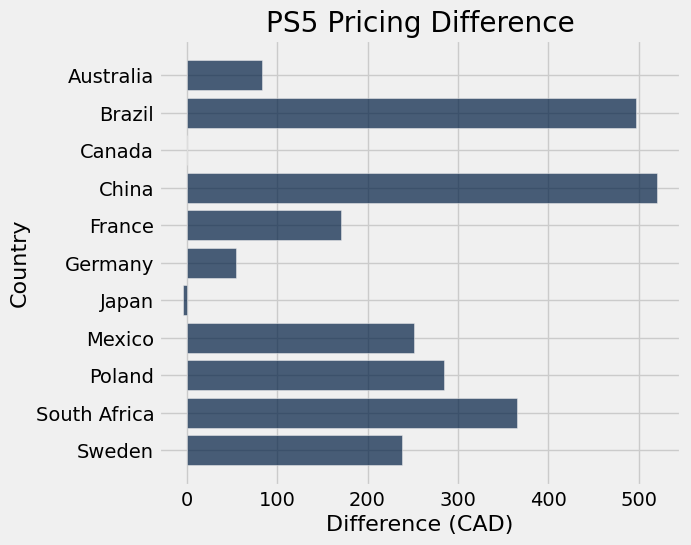

In [ ]:
# plotting the difference in a horizontal bar chart
ps5_pricing_tbl.barh('Country', 'Difference')
plots.title('PS5 Pricing Difference')
plots.xlabel('Difference (CAD)')
plots.savefig('ps5_pricing_difference.png', bbox_inches = 'tight')

# External Factor: Purchasing Power Index

We thought that the purchasing power of different currencies could have an effect on the pricing difference of the PS5 in various countries. To see if this is the case, we will first scrape the web for the purchasing power index of the currencies we need and add them to our table.

In [ ]:
# identify an external factor, join it with the ps5 pricing table, and plot the result
# we are using the purhcasing power index for our comparison
PPI_url = 'https://worldpopulationreview.com/country-rankings/cost-of-living-by-country'
PPI_request = requests.get(PPI_url)
PPI_soup = BeautifulSoup(PPI_request.text, 'html.parser')
PPI_tables = PPI_soup.find_all('table')
PPI_table = PPI_tables[3]
PPI_data = scrape_table(PPI_table)

PPI_tbl = PPI_data.select('Country', 'LPPI (Numbeo 2023)') # select only the rows I am using
ps5_pricing_joined = ps5_pricing_tbl.join('Country', PPI_tbl, 'Country') # join the tables by country
ps5_pricing_joined = ps5_pricing_joined.relabeled('LPPI (Numbeo 2023)', 'Purchasing Power Index') # cleaning up labels for readability
ps5_pricing_joined

<ipython-input-3-fa3cfb19b358>:4: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))


Country,Local Price,Code,Price (CAD),Difference,Purchasing Power Index
Australia,815.83,AUD,741.66,83.19,89.3
Brazil,4873.21,BRL,1154.79,496.32,28
Canada,658.47,CAD,658.47,0,90.9
China,6082.4,CNY,1178.76,520.29,58.2
France,555.48,EUR,829.08,170.61,81.5
Germany,478.02,EUR,713.46,54.99,100.2
Japan,70376.6,JPY,654.24,-4.23,94.3
Mexico,13368.9,MXN,909.45,250.98,39.9
Poland,2735.54,PLN,943.29,284.82,59.9
South Africa,13266.6,ZAR,1023.66,365.19,78.1


Now let's plot the purchasing power of countries against the difference in price for the PS5 to see if there is any correlation.

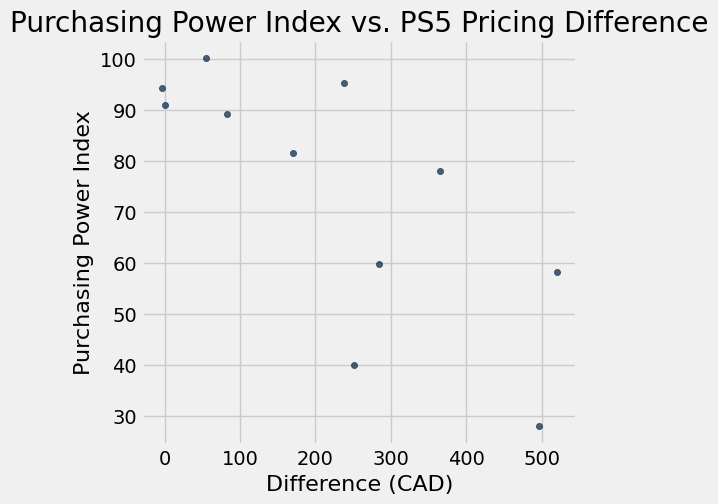

In [ ]:
# creating a scatter plot of the price difference vs the purchasing power index
ps5_pricing_joined.scatter('Difference', 'Purchasing Power Index')
plots.title('Purchasing Power Index vs. PS5 Pricing Difference')
plots.xlabel('Difference (CAD)')
plots.savefig('ppi_vs_ps5_pricing.png', bbox_inches = 'tight')

Let's take a look at the correlation coefficient between purchasing power index and the price difference to see how well they are correlated.

In [ ]:
# calculating correlation coefficient
r = correlation(ps5_pricing_joined, 'Difference', 'Purchasing Power Index')
r

-0.74980006840100077

As we can see the correlation is negative and relativley strong. Therefore as purchasing power decreases, the PS5 seems to get more expensive.